# Autoencoder

## 1. Settings

### 1) Import required libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

## 2. Data

### 1) Download Data

In [ ]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [ ]:
mnist_train[0][1]           # label

9

### 2) Set DataLoader

In [ ]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
len(dataloaders["train"])

196

## 3. Model & Optimizer

### 1) Model

In [ ]:
# build your own autoencoder
# in my case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 28*28),
            nn.Sigmoid()                           # activation function
        )

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.view(-1, 28*28)                          # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                      # hidden vector
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)                 # final output. resize to input's size
        return out, encoded


### 2) Loss func & Optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [ ]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [ ]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1170
val Loss: 0.0692

Epoch 1/9
----------
train Loss: 0.0630
val Loss: 0.0571

Epoch 2/9
----------
train Loss: 0.0515
val Loss: 0.0456

Epoch 3/9
----------
train Loss: 0.0422
val Loss: 0.0397

Epoch 4/9
----------
train Loss: 0.0381
val Loss: 0.0364

Epoch 5/9
----------
train Loss: 0.0348
val Loss: 0.0330

Epoch 6/9
----------
train Loss: 0.0315
val Loss: 0.0300

Epoch 7/9
----------
train Loss: 0.0289
val Loss: 0.0277

Epoch 8/9
----------
train Loss: 0.0268
val Loss: 0.0259

Epoch 9/9
----------
train Loss: 0.0251
val Loss: 0.0244

Training complete in 1m 7s
Best val Loss: 0.024406


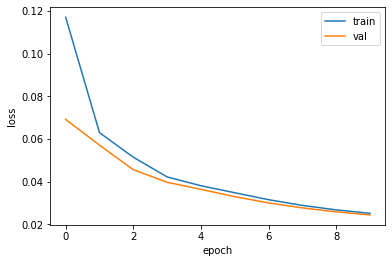

In [ ]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Check with Test Image

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.024046513670682907


torch.Size([16, 28, 28])


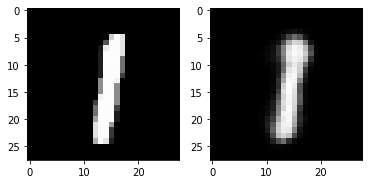

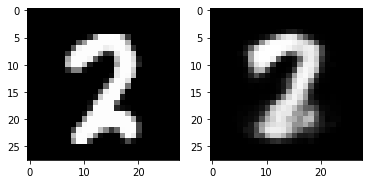

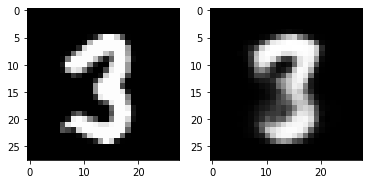

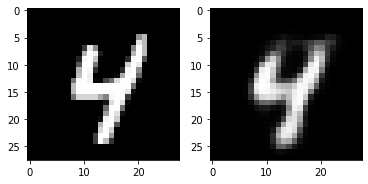

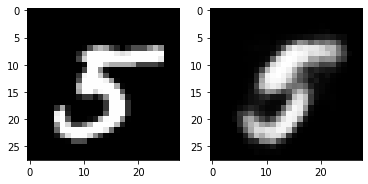

In [ ]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [ ]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [ ]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs)

In [ ]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

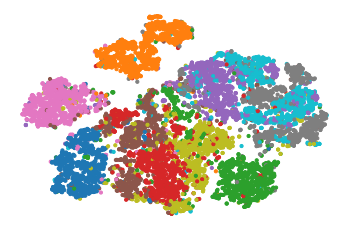

In [ ]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

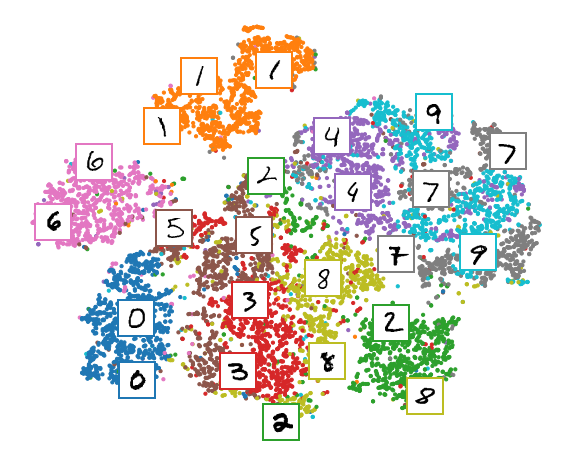

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Denoising Autoencoder

In [ ]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [ ]:
# It's all the same except for one: adding noise to inputs
# copy train_model() code and just add 'noise part'
# Hint: You can make noise like this.
# noise = torch.zeros(inputs.size(0), 1, 28, 28)
# nn.init.normal_(noise, 0, 0.1)

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise = torch.zeros(inputs.size(0), 1, 28, 28)
                nn.init.normal_(noise, 0, 0.1)
                noise = noise.to(device)
                inputs = inputs.to(device)
                noise_inputs = inputs + noise

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(noise_inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [ ]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1153
val Loss: 0.0703

Epoch 1/9
----------
train Loss: 0.0658
val Loss: 0.0596

Epoch 2/9
----------
train Loss: 0.0530
val Loss: 0.0464

Epoch 3/9
----------
train Loss: 0.0433
val Loss: 0.0408

Epoch 4/9
----------
train Loss: 0.0392
val Loss: 0.0374

Epoch 5/9
----------
train Loss: 0.0357
val Loss: 0.0337

Epoch 6/9
----------
train Loss: 0.0319
val Loss: 0.0303

Epoch 7/9
----------
train Loss: 0.0293
val Loss: 0.0283

Epoch 8/9
----------
train Loss: 0.0276
val Loss: 0.0268

Epoch 9/9
----------
train Loss: 0.0260
val Loss: 0.0253

Training complete in 1m 14s
Best val Loss: 0.025279


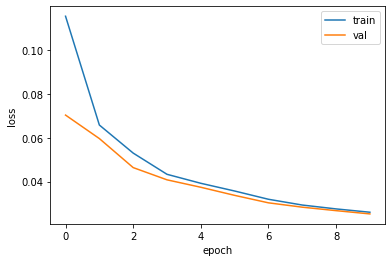

In [ ]:
plt.plot(train_loss_history_D, label='train')
plt.plot(val_loss_history_D, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
      noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
      noise = noise.to(device)
      inputs = inputs.to(device)
      noise_inputs = inputs + noise

      outputs, encoded = best_model_D(noise_inputs)
      test_loss = loss_func(outputs, inputs)
      
      running_loss += test_loss.item()* inputs.size(0)

  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss) 

0.025239006447792055


torch.Size([16, 28, 28])


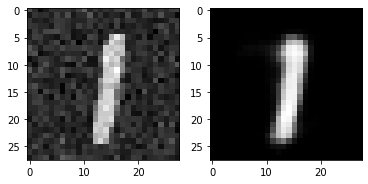

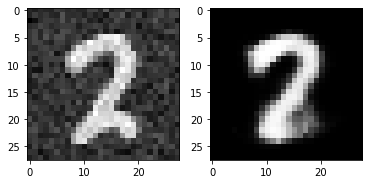

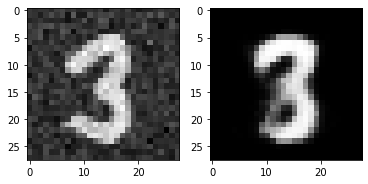

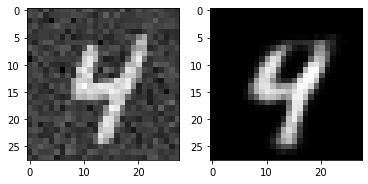

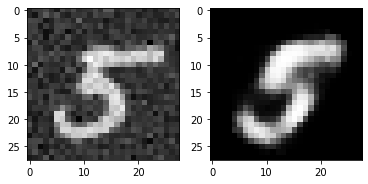

In [ ]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()